# Introduction to Data Science
## Feature Selection and Decision Tree Modeling

Sophia Maria Tsilerides

***

With supervised segmentation, we must asses our features so that our classifers create groups of similar characteristics. These become our "informative attributes." However, target attributes rarely split a group perfectly. There might only be one example of a group, not all the attributes may be binary, or some attributes may be numeric and a range is needed to split them and treat them as categories. Purity measure gives us a formula that evaluates how well each attribute splits a set of examples into segments. 

Purity measures inclue entropy and information gain. Entropy tells us how impure one individual subset is, in other words, how much disorder is in a set. We want entropy to be low. Information gain measures how much an attribute improves entropy over the whole segmentation it creates. Strictly speaking, information gain measures the change in entropy due to any amount of new information being added. We want information gain high.

The formulas for Mutual Information, Entropy and Conditional Entropy are given by:

$$\text{Mutual Information} = \sum_{y \in Y} \sum_{x \in X} p(x, y) \cdot log\frac{p(x, y)}{p(x)p(y)}$$

$$\text{Entropy} = H(Y) = -\sum_{y \in Y} p(y) \cdot log(p(y))$$

$$\text{Conditional Entropy} = H(Y \mid X) = \sum_{x \in X} p(x) \cdot H(Y \mid X = x)$$

Mathematically, $\text{Mutual Information} = \text{Information Gain}$, where $\text{Information Gain} = H(Y) – H(Y \mid X)$. 

### Preparing a Training Set and Training a Decision Tree
Here, we build a predictive model using Decision Trees and the data set `cell2cell_data.csv`.

These historical data consist of 39,859 customers: 19,901 customers that churned (i.e., left the company) and 19,958 that did not churn (see the `"churndep"` variable). Here are the data set's 11 possible predictor variables for churning behavior: 

```
Pos.  Var. Name  Var. Description
----- ---------- --------------------------------------------------------------
1     revenue    Mean monthly revenue in dollars
2     outcalls   Mean number of outbound voice calls
3     incalls    Mean number of inbound voice calls
4     months     Months in Service
5     eqpdays    Number of days the customer has had his/her current equipment
6     webcap     Handset is web capable
7     marryyes   Married (1=Yes; 0=No)
8     travel     Has traveled to non-US country (1=Yes; 0=No)
9     pcown      Owns a personal computer (1=Yes; 0=No)
10    creditcd   Possesses a credit card (1=Yes; 0=No)
11    retcalls   Number of calls previously made to retention team
```

The 12th column, the dependent variable `"churndep"`, equals 1 if the customer churned, and 0 otherwise. 

Using a model that predicts churn can enable the company to reach out to at-risk customers and try to prevent it. Additionally, understanding the drivers of churn gives valuable feedback for the company to improve their service. From these insights, strategies for business relationship management can be developed to improve churn rates.  

First, we will load the data and prepare it for modeling. The features are already processed, so the only thing we need to do is split the data into training and testing, with testing having 80% of the data chosen uniformly at random without replacement.

When a sample is selected at random, each member of the population is equally likely to be selected. There are many different ways to select a sample from a population. To make valid inferences about a population, we must choose a random sample very carefully so that it accurately represents the population and there is no selection bias. We want to avoid selection bias so that our churn model can be generalizable to real world data and we can estimate the "churndep" parameter given the data we have. 

Our probability of being sampled must be independent from our parameters. In other words, the data in the churn data set can have no bearing our sampling mechanism. 

Here, we use the pandas method "sample" to randomly select 80% of the data points without replacement and store them in the training dataset. This is equivalent to introducing a 3rd variable (selected or not selected) that the sampling mechanism depends on. This works because the data samples are bias towards this variable, but it is not part of our analysis. Therefore, the sampling mechanism is independent from the variables under study and there is no selection bias to the parameters being learned. 

A test to check if our probability distributions of, say, S: probability of being sampled, and the probability distribution of our parameters are independent. That is P(S|parameters) = P(S).

In [1]:
import pandas as pd
import os

directory = os.getcwd()
data = pd.read_csv(directory + '/cell2cell_data.csv', sep=',') 
data = pd.DataFrame(data)
data.columns = ['revenue', 'outcalls', 'incalls', 'months', 'eqpdays', 'webcap', 'marryyes','travel','pcown','creditcd','retcalls', 'churndep']

train_df = data.sample(frac=0.8, replace=False, random_state=1)
test_df = data[~data.isin(train_df)].dropna()

In [2]:
len(train_df)

31886

In [3]:
len(test_df)

7972

Next, we build and train a decision tree classifier using `DecisionTreeClassifier()` from the scikit-learn package. Using `criterion='entropy'` when instantiating an instance of `DecisionTreeClassifier()`, we can extract the built in feature importances and make a bar plot sorted by increasing feature importance values.

In [4]:
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion='entropy')

X = train_df.drop('churndep', axis=1)
y = train_df['churndep']
model = model.fit(X,y)

Text(0.5,0,'Relative Importance')

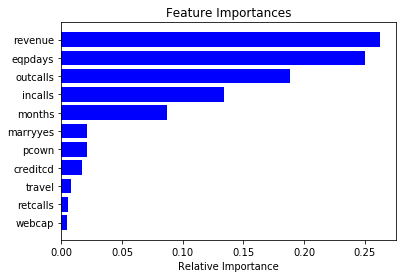

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

importances = model.feature_importances_
indices = np.argsort(importances)
features = data.columns[0:12]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

Identifying which variables are important help detect and improve services to mitigate churn. From the decision tree model, we see that the three most important features for predicting church in the decision tree are `revenue`, `eqpdays` and `outcalls`. The metric used in the model is the normalized Gini index for which a high value makes the feature more important. To know more about the relationship between the variables, we must calculate the correlation. The correlation between these important features and the target variable reveal more information about the relationship between them. 

Let's look at the correlation between the top 3 most important features.

In [6]:
imp_features = data[['revenue', 'eqpdays', 'outcalls', 'churndep']]
imp_features.drop('churndep', axis=1).apply(lambda x: x.corr(data.churndep))

revenue    -0.013561
eqpdays     0.112698
outcalls   -0.037223
dtype: float64

The relationship between churn and the mean monthly revenue of the account holder is negative. This implies that as revenue increase, the likelihood of churn goes down. This makes sense since account holders that can afford the service will not likely churn. However, depending on the spread of the revenue, it may imply that the service is too expensive for the average household. 

The relationship between churn and the number of days an account holder has their equipment is positive. This means that the variables change in the same direction: the longer a customer has their phone, the less likely they are to churn. The "real-life" connection for this statistic is basic habitual human behavior. People that have the service and phone longer are reluctant to change.

Lastly, the relationship between churn and the mean number of outbound calls a user makes has a negative correlation. Similar to the relationship with revenue, a negative correlation means the variables change in the opposite direction. This may mean that the more calls someone has to make, the more frustrated they are. It could be because the service is bad and the user has to always call back or they are making a lot of calls to customer service. It would be worth looking into the location of the users and locations of cell towers to make sure the company is providing satisfactory coverage.

Let's take a look at the accuracies for the Decision Tree Model using the classifier built to predict "churndep" on both the train_df and test_df data sets. 

In [7]:
X_train = train_df.drop('churndep', axis=1)
y_train = train_df['churndep']
X_test = test_df.drop('churndep', axis=1)
y_test = test_df['churndep']

In [8]:
from sklearn.metrics import accuracy_score

#on training
y_predict_train = model.predict(X_train)
accuracy_score(y_train, y_predict_train)

0.9998431913692529

In [9]:
#on testing
y_predict_test = model.predict(X_test)
accuracy_score(y_test, y_predict_test)

0.5308580030105369

The high accuracy on training data suggests overfitting. The model predicts too closely the outcomes in the training dataset and does not perform well in the field. This may be due to the simplicity of the model. When a model is not allowed to be complex enough, it is not very accurate.

The accuracy of the testing dataset is about 53%, which is not much better than 50/50 guessing. A model should have a higher accuracy than just the base rate: the percent of “yes” that is in the original dataset, which for this dataset is 50%.

In [10]:
len(data[data['churndep'] == 1])/ len(data)

0.49927241708063624

One issue might be the default options we left in the decision tree. They are probably not optimal. We need to analyze whether tuning the parameters can improve the accuracy of the classifier.  

In [11]:
split_weights = []
min_samples_split_values=[]

for i in np.linspace(.3, .5, 10):
    split_weights.append(i*i)

for i in split_weights:
    min_samples_split_values.append(int(i*len(X_train)))

min_samples_split_values

[2869, 3310, 3783, 4286, 4822, 5389, 5987, 6617, 7278, 7971]

In [12]:
leaf_weights = []
min_samples_leaf_values=[]

for i in np.linspace(.01, .2, 10):
    leaf_weights.append(i*i)

for i in leaf_weights:
    min_samples_leaf_values.append(int(i*len(X_train)))

min_samples_leaf_values

[3, 30, 86, 171, 284, 425, 595, 793, 1020, 1275]

Choosing the parameters linearly did not improve accuracy scores because it only tested splits from chunks of the data without considering that the ideal split is not at some even interval. Therefore, it would be beneficial to split the metric for parameterization exponentially. Also, the number of leaf splits is less than the sample split values because a split will not happen if there are less than a certain number of records specified by min_samples_split in a node, so it would be redundent to test for it.

For each combination of values we build a new classifier and check the classifier's accuracy on the test data. Then, we plot the test set accuracy to view our results visually. 

In [13]:
test_results = []
sample_split = []
leaf_split = []

for i in min_samples_split_values:
    for j in min_samples_leaf_values:
        model = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=i, min_samples_leaf= j)
        model = model.fit(X_train,y_train)
        
        y_predict_test = model.predict(X_test)

        test_results.append(accuracy_score(y_test, y_predict_test))
        sample_split.append(i)
        leaf_split.append(j)

plot_df = {'accuracy': test_results, 'sample_split': sample_split, 'leaf_split': leaf_split}
plot_df = pd.DataFrame(plot_df)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

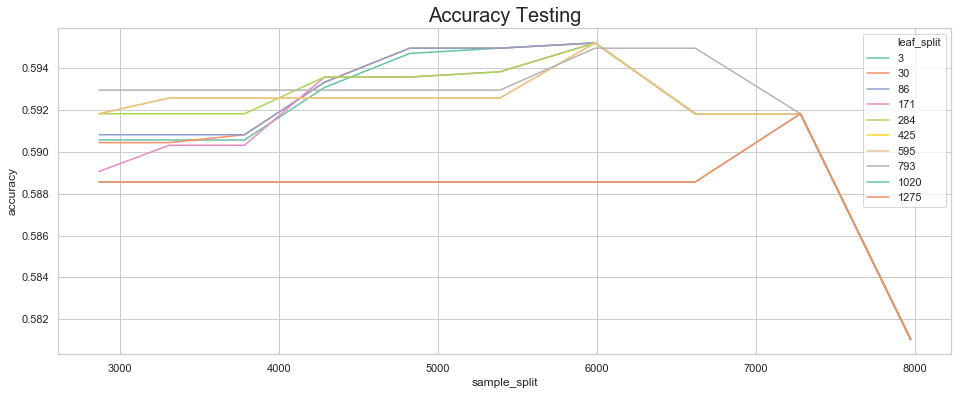

In [15]:
plt.figure(figsize=(16, 6));
sns.set(style="whitegrid");

sns.lineplot(x="sample_split", y="accuracy", hue="leaf_split", data=plot_df, palette=sns.color_palette("Set2", 10));
plt.title("Accuracy Testing",fontsize=20);

The highest accuracy is at 59.5% when the sample_split is about 6,000 samples and the leaf_split is less than 400 samples. This makes sense since as we consider more of the samples at each node, the model cannot learn enough about the data and it underfits.